# Exercise 6 - Simple features

Solving the correspondance problem in computer vision is done in a three step process:
- Recognize features in each image.
- Recognize patterns of features, that corresponds between each image. So called descriptors.
- Match the descriptors.

In this week we will focus on the features or key points in a single image. What is important is that such features should be recognizable even if the image is rotated, translated or enhanced - so that it is possible to find the same features in multiple images. One such good feature is a corner point, as in a corner the image gradient (describing how the color itensity changes in an area) is changing a lot when moving slightly away from the corner. Similarly edges can be a good, but not as poweful feature. Edges are however a more useful feature in many cases, as they are often required to navigate or detect more advanced structures.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Harris corner detection

Harris corner detection relies on calculating the "cornerness" of each area of an image, using $c(x,y) = g * \delta I(x,y)^2$. Where g is a gaussian kernel to blurr the image, making it less suseptable to noise, and the delta I is the gradient in a small area around a point x,y. 

Using a first order taylor polynomial to approximate the gradient we get the average Hessian matrix: $c(x,y) = \delta^T * C(x,y) * \delta$.

delta is a small vector, representing a small shift away from x,y in any direction. The harrison metric is to look at $r(x,y) = det(C) - k * trace(C) = \lambda _1 \lambda _2 - k*(\lambda _1 + \lambda _2)$, where k is a free parameter, typically 0.06. r(x,y) is ...:
- r > 0: Corners (both large lambdas) - so the gradient moves a lot in both directions.
- r < 0: edges (one lambda big, one small) - so the gradient changes a lot more while moving along one axis then the other.
- Both lambdas small? Typically a flat area/surface.

#### 6.1 Gaussian kernel g

Size of gaussian filter is given by the 3, 4, or 5 sigma rule:
- How far do you want to extend the filter? To capture 100% of gaussian distribution you need (-inf, inf). But if you make it 2 * 5 * sigma (2 since you go on both sides of $\mu$), then you capture 99.7% of the distribution.

In [146]:
def gaussian1DKernel(sigma, rule=5, eps=0):
    """
    Returns 1D filter kernel g, and its derivative gx.
    """
    if eps:
        filter_size=eps
    else:
        filter_size = np.ceil(sigma*rule)
    x = np.arange(-filter_size, filter_size+1) # filter
    # Make kernel
    g = 1/(np.sqrt(2*np.pi*sigma**2)) * np.exp(-x**2 / (2*sigma**2))
    #g /= g.sum() # Normalize filter to 1. No need with normalization factor
    g = g.reshape(-1, 1) # Make it into a col vector
    # Make the derivate of g.
    # NB! Need the normalization term of the gaussian
    gx = -(-x**2)/(sigma**2) * g[:,0]
    gx = gx.reshape(-1, 1) # Make it into a col vector
    return g, gx, x

In [147]:
g, gx, x = gaussian1DKernel(sigma=10)

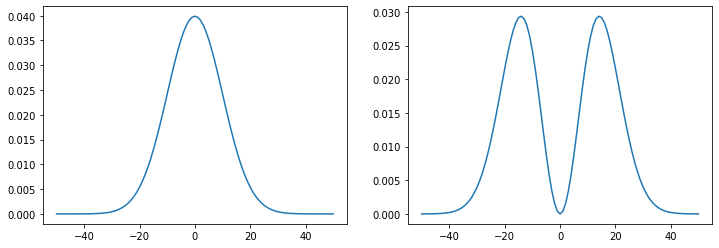

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(x, g)
ax[1].plot(x, gx)

#### 6.2 Gaussian smoothing

The fact that gaussian is seperable, we can smooth one direction (x, y) at a time, using the same kernel, or different ones. The end result is not affected by the order of smoothings (commutative). 

Getting the derivatives of an image can be done using the gaussian to blurr the image first: to make the image into a nice smooth differentiatable surface, and then using the derivative of the gaussian to differentiate the image. What is differentiating an image? It is to see how quickly the color intensity of the iamge changes in all directions => which is what we gain by using the gx kernel.

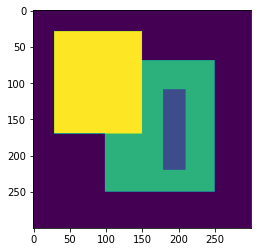

In [170]:
def get_rgb(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    image = cv2.merge([r,g,b])
    return image
#image = get_rgb("week6_data/TestIm1.png")
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

testIM_1 = cv2.imread("week06_data/TestIm1.png")
testIM_1 = cv2.cvtColor(testIM_1, cv2.COLOR_BGR2GRAY)
plt.imshow(testIM_1)

In [171]:
def gaussianSmoothing(im, sigma):
    """
    Returns the gaussian smoothed image I, and the image derivatives Ix and Iy.
    """
    # 1 obtain the kernels for gaussian and for differentiation.
    g, gx, _ = gaussian1DKernel(sigma=sigma)
    # 2 Filter the image in both directions and diff in both directions
    I = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T) # smooth I = g * g.T * I
    # 3 Differentiate - d/dx I = g * gx.T * I 
    Ix = cv2.filter2D(cv2.filter2D(im, -1, gx.T), -1, g)
    Iy = cv2.filter2D(cv2.filter2D(im, -1, g.T), -1, gx)
    return I, Ix, Iy

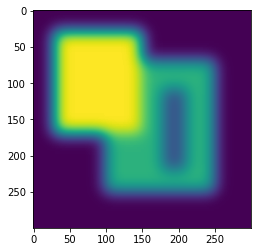

In [172]:
I, Ix, Iy = gaussianSmoothing(testIM_1, sigma=10)
plt.imshow(I)

#### 6.3 Smooth / average hessian

A key component in the Harris corner detection is the smooth hessian of the image. The eigenvalues / dynamics of the hessian matrix gives how quickly the gradient is changing in the different directions.

In [173]:
def smoothedHessian(im, sigma, epsilon):
    """
    Calculates smooth/average hessian of image.
    Sigma is the width used to calculate the derivatives, while epsilon is used for the kernel inside Hessian.
    """
    _, Ix, Iy = gaussianSmoothing(im, sigma=sigma)
    g_e, _, _ = gaussian1DKernel(sigma=sigma, eps=epsilon)

    C = np.array([  [cv2.filter2D(cv2.filter2D(Ix**2, -1, g_e), -1, g_e.T), cv2.filter2D(cv2.filter2D(Ix*Iy, -1, g_e), -1, g_e.T)],
                    [cv2.filter2D(cv2.filter2D(Ix*Iy, -1, g_e), -1, g_e.T), cv2.filter2D(cv2.filter2D(Iy**2, -1, g_e), -1, g_e.T)]])
    return C

In [178]:
C = smoothedHessian(testIM_1, sigma=10, epsilon=2*10*3)
C.shape

(2, 2, 300, 300)

In [177]:
C[:, :, 33, 33]

array([[103, 123],
       [123, 104]], dtype=uint8)

In [187]:
C[0, 0, :, :].shape

(300, 300)

#### 6.4 Harris measure

In [188]:
def harrisMeasure(im, sigma, epsilon, k):
    C = smoothedHessian(im, sigma=sigma, epsilon=epsilon)
    a, b, c = C[0, 0, :, :], C[1, 1, :, :], C[0, 1, :, :]
    r = a*b - c**2 - k * (a + b)**2
    return r

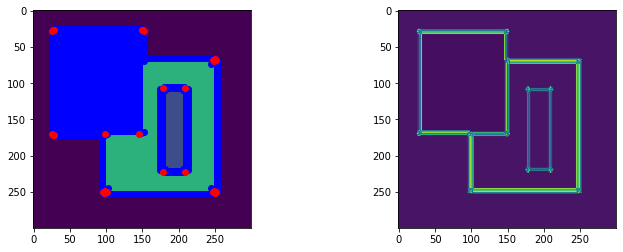

In [314]:
testIM_1 = cv2.imread("week06_data/TestIm1.png")
testIM_1 = cv2.cvtColor(testIM_1, cv2.COLOR_BGR2GRAY)
sigma=0.7
r = harrisMeasure(testIM_1, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06) 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].imshow(testIM_1)
ax[1].imshow(r)
pos = np.where(r<0)
ax[0].scatter(pos[1][:], pos[0][:], c="blue")
pos = np.where(r>r.max()*0.977)
ax[0].scatter(pos[1][:], pos[0][:], c="red")

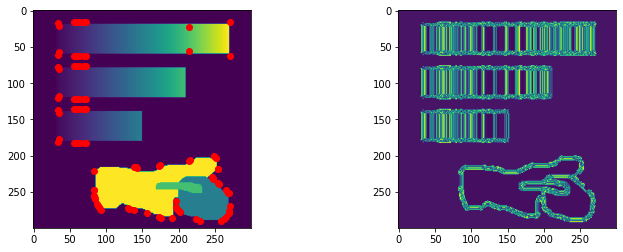

In [304]:
testIM_2 = cv2.imread("week06_data/TestIm2.png")
testIM_2 = cv2.cvtColor(testIM_2, cv2.COLOR_BGR2GRAY)
sigma=0.7
r = harrisMeasure(testIM_2, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06) 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].imshow(testIM_2)
ax[1].imshow(r)
pos = np.where(r>r.max()*0.999)
ax[0].scatter(pos[1][:], pos[0][:], c="red")

#### 6.5 Non max supression 


In [469]:
def cornerDetector(im, sigma, epsilon, k, tau):
    """
    Returns list of points that are both larger than threshold tau, and local maxima.
    Typically 0.1*rmax < tau < 0.8*rmax.
    """
    r = harrisMeasure(im, sigma=sigma, epsilon=epsilon, k=k) 
    under_tau = np.where(r<tau*r.max())
    r[under_tau[0][:], under_tau[1][:]] = 0
    # Non-max supression
    change = True
    while change:
        change = False
        test = np.where(r>0)
        for k in range(len(test[0])):
            i = test[0][k]
            j = test[1][k]
            try:
                if r[i, j] > r[i+1, j] and r[i, j] >= r[i-1, j] and r[i, j] > r[i, j+1] and r[i, j] >= r[i, j-1] and (r[i+1, j]+r[i-1, j]+r[i, j+1]+r[i, j-1])>0:
                    r[i+1, j] = 0
                    r[i-1, j] = 0
                    r[i, j+1] = 0
                    r[i, j-1] = 0
                    change=True
            except IndexError:
                r[i, j] = 0
                change=True

    corners = np.where(r>0)
    return corners

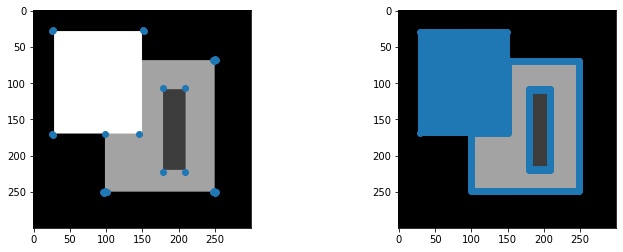

In [428]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sigma=0.7
c = cornerDetector(testIM_1, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06, tau=0.977)
ax[0].imshow(testIM_1, cmap="gray")
ax[0].scatter(c[1][:], c[0][:])

sigma=0.25
c = cornerDetector(testIM_1, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06, tau=0.4)
ax[1].imshow(testIM_1, cmap="gray")
ax[1].scatter(c[1][:], c[0][:])


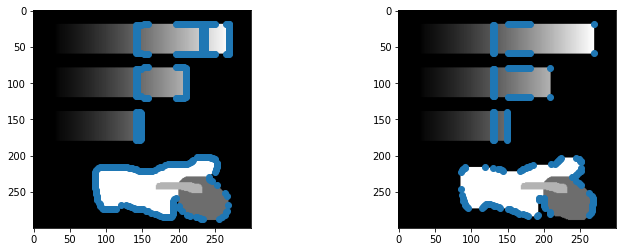

In [418]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sigma=0.3
c = cornerDetector(testIM_2, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06, tau=0.99)
ax[0].imshow(testIM_2, cmap="gray")
ax[0].scatter(c[1][:], c[0][:])

sigma=0.25
c = cornerDetector(testIM_2, sigma=sigma, epsilon=2*np.ceil(sigma*8), k=0.06, tau=0.971)
ax[1].imshow(testIM_2, cmap="gray")
ax[1].scatter(c[1][:], c[0][:])

### Canny edge detection

Just like many other imaging operations the Canny edge detector is available in both Matlab and \
OpenCV. Instead of implementing it ourselves, let us start using someone else’s implementation.

#### 6.6 Testing Canny

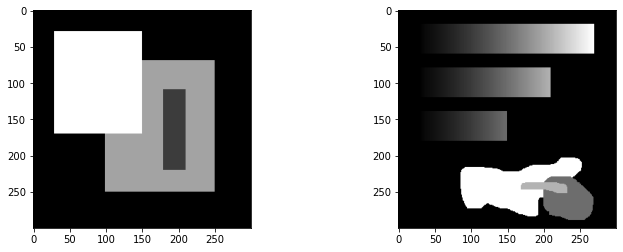

In [429]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].imshow(testIM_1, cmap="gray")
ax[1].imshow(testIM_2, cmap="gray")


In [448]:
""" Canny
    parameters:
        - image to detect on
        - thresholds: upper and lower gradient intensity
        - apature size: size of kernel. Default is 3x3
        - L2 gradient: specify the equation for gradient magnitude. Default false.
    return:
        - grayscale edge detections


"""


edges_1 = cv2.Canny(testIM_1, 0, 10)
edges_2 = cv2.Canny(testIM_2, 0, 10)

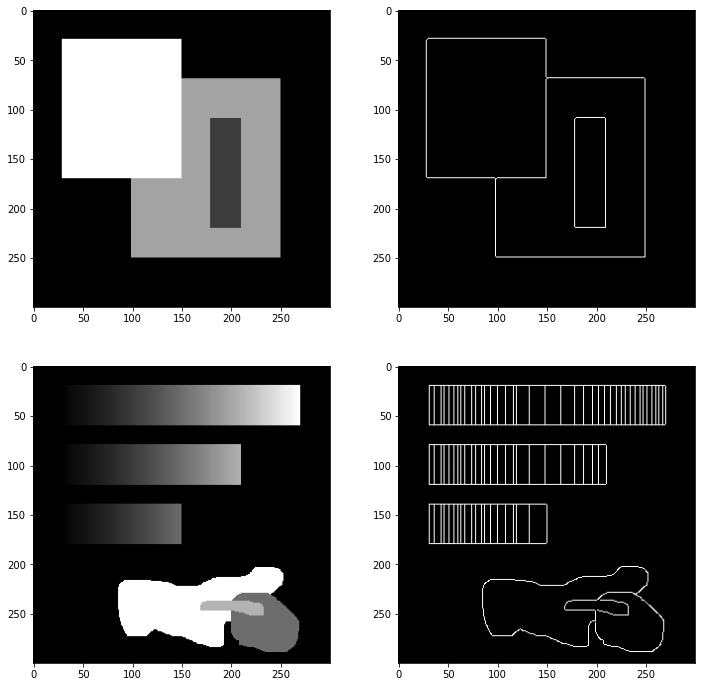

In [449]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax[0, 0].imshow(testIM_1, cmap="gray")
ax[0, 1].imshow(edges_1, cmap="gray")
ax[1, 0].imshow(testIM_2, cmap="gray")
ax[1, 1].imshow(edges_2, cmap="gray")

#### 6.7 What is the effect of the threshold parameter?


The thresholds decides which of all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded.

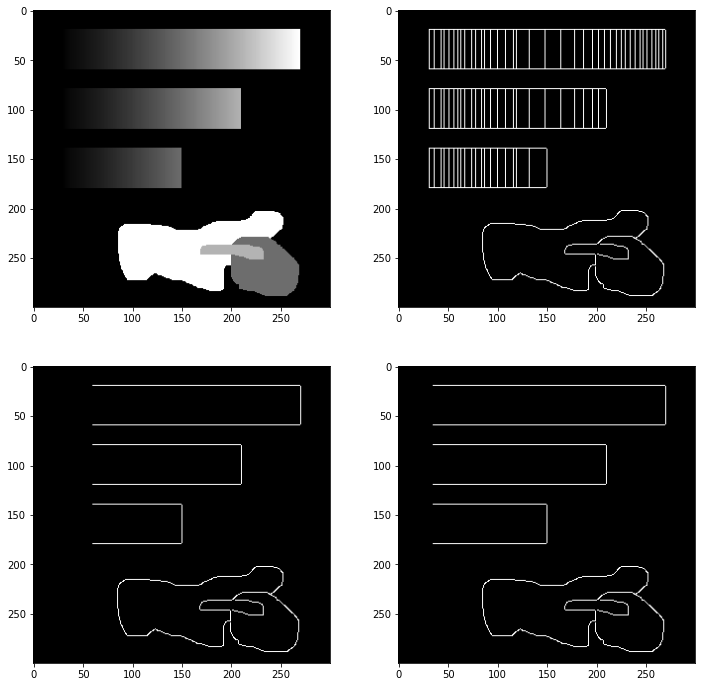

In [459]:
edges_1 = cv2.Canny(testIM_2, 0, 10) # All above 10 are concidered edges, and all others are also edges if they are connected!
edges_2 = cv2.Canny(testIM_2, 100, 100) # All above 100 are edges, all below are not.
edges_3 = cv2.Canny(testIM_2, 30, 50) # All below 30 are not, all above 50 are, all in between are edges if connected.

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax[0, 0].imshow(testIM_2, cmap="gray")
ax[0, 1].imshow(edges_1, cmap="gray")
ax[1, 0].imshow(edges_2, cmap="gray")
ax[1, 1].imshow(edges_3, cmap="gray")

#### Playing around with other images

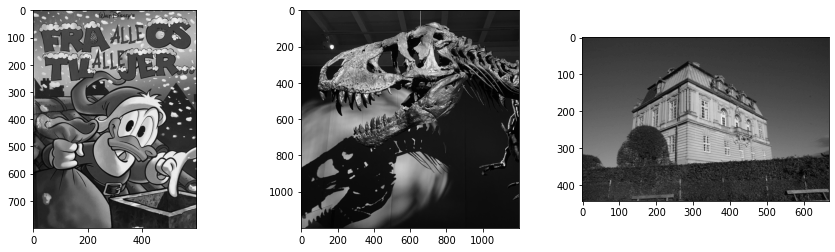

In [467]:
donald = cv2.imread("week06_data/Donald.png")
donald = cv2.cvtColor(donald, cv2.COLOR_BGR2GRAY)
dino = cv2.imread("week06_data/tristan.png")
dino = cv2.cvtColor(dino, cv2.COLOR_BGR2GRAY)
house = cv2.imread("week06_data/eremitage1.png")
house = cv2.cvtColor(house, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax[0].imshow(donald, cmap="gray")
ax[1].imshow(dino, cmap="gray")
ax[2].imshow(house, cmap="gray")

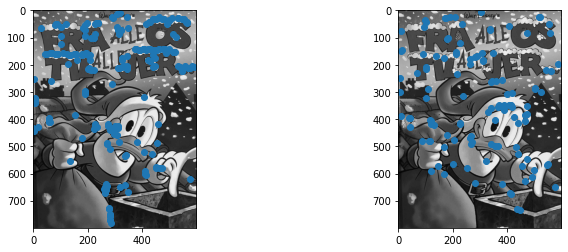

In [479]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sigma=0.25
c = cornerDetector(donald, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06, tau=0.99)
ax[0].imshow(donald, cmap="gray")
ax[0].scatter(c[1][:], c[0][:])

sigma=0.3
c = cornerDetector(donald, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06, tau=0.9999)
ax[1].imshow(donald, cmap="gray")
ax[1].scatter(c[1][:], c[0][:])


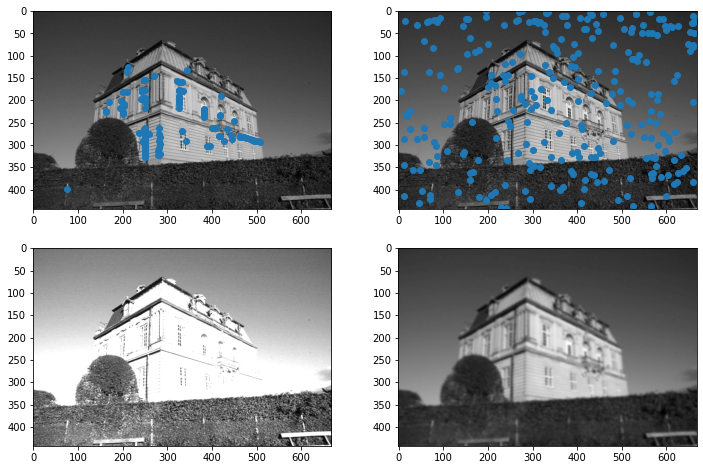

In [497]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

sigma=0.25
c = cornerDetector(house, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06, tau=0.99)
ax[0, 0].imshow(house, cmap="gray")
ax[0, 0].scatter(c[1][:], c[0][:])

I, _, _ = gaussianSmoothing(house, sigma=sigma)
ax[1, 0].imshow(I, cmap="gray")

sigma=2
c = cornerDetector(house, sigma=sigma, epsilon=15, k=0.06, tau=0.9999)
ax[0, 1].imshow(house, cmap="gray")
ax[0, 1].scatter(c[1][:], c[0][:])

I, _, _ = gaussianSmoothing(house, sigma=sigma)
ax[1, 1].imshow(I, cmap="gray")


**NB** seems a bit odd that increasing sigma makes the algorithm so bad. 

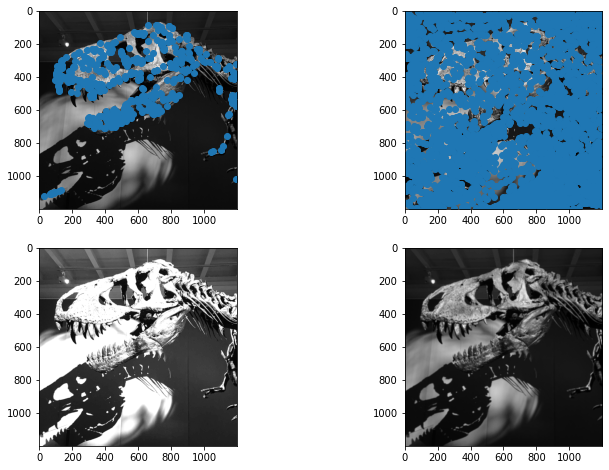

In [498]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

sigma=0.25
c = cornerDetector(dino, sigma=sigma, epsilon=2*np.ceil(sigma*3), k=0.06, tau=0.99)
ax[0, 0].imshow(dino, cmap="gray")
ax[0, 0].scatter(c[1][:], c[0][:])

I, _, _ = gaussianSmoothing(dino, sigma=sigma)
ax[1, 0].imshow(I, cmap="gray")

sigma=2
c = cornerDetector(dino, sigma=sigma, epsilon=15, k=0.06, tau=0.9999)
ax[0, 1].imshow(dino, cmap="gray")
ax[0, 1].scatter(c[1][:], c[0][:])

I, _, _ = gaussianSmoothing(dino, sigma=sigma)
ax[1, 1].imshow(I, cmap="gray")
